In [21]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

import my_module

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")

cm = px.colors.sequential.Emrld

warnings.filterwarnings("ignore")

In [22]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

df = pd.concat([train, test], ignore_index=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


NO EDA for now


<a id="2"></a>

# 2. Preprocessing


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

As the first attemp, I will delete all columns with a lot of nan values


In [24]:
df = my_module.delete_nan_column(df, 0.25)

numeric_features = my_module.get_type_features(df, ["int64", "float64"])
categorical_features = my_module.get_type_features(df, ["object"])

In [25]:
df[numeric_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2433 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2896 non-null   float64
 8   BsmtFinSF1     2918 non-null   float64
 9   BsmtFinSF2     2918 non-null   float64
 10  BsmtUnfSF      2918 non-null   float64
 11  TotalBsmtSF    2918 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2917 non-null   float64
 17  BsmtHalfBath   2917 non-null   float64
 18  FullBath

Imput median values in the numeric columns


In [26]:
for col in numeric_features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df[[col]] = imp.fit_transform(df[[col]])
df[numeric_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   float64
 1   LotFrontage    2919 non-null   float64
 2   LotArea        2919 non-null   float64
 3   OverallQual    2919 non-null   float64
 4   OverallCond    2919 non-null   float64
 5   YearBuilt      2919 non-null   float64
 6   YearRemodAdd   2919 non-null   float64
 7   MasVnrArea     2919 non-null   float64
 8   BsmtFinSF1     2919 non-null   float64
 9   BsmtFinSF2     2919 non-null   float64
 10  BsmtUnfSF      2919 non-null   float64
 11  TotalBsmtSF    2919 non-null   float64
 12  1stFlrSF       2919 non-null   float64
 13  2ndFlrSF       2919 non-null   float64
 14  LowQualFinSF   2919 non-null   float64
 15  GrLivArea      2919 non-null   float64
 16  BsmtFullBath   2919 non-null   float64
 17  BsmtHalfBath   2919 non-null   float64
 18  FullBath

In [27]:
px.imshow(
    df[numeric_features].corr(), color_continuous_scale=cm, width=1000, height=1000
)

In [28]:
px.imshow(df[numeric_features].corr()[["SalePrice"]].T, color_continuous_scale=cm)

In [29]:
predictive_features = my_module.get_corr_features(
    df[numeric_features].corr()["SalePrice"], 0.6
)
df_final = df[predictive_features].copy(deep=True)
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,7.00,856.00,856.00,1710.00,2.00,548.00,208500.00
1,6.00,1262.00,1262.00,1262.00,2.00,460.00,181500.00
2,7.00,920.00,920.00,1786.00,2.00,608.00,223500.00
3,7.00,756.00,961.00,1717.00,3.00,642.00,140000.00
4,8.00,1145.00,1145.00,2198.00,3.00,836.00,250000.00


Get the features with predictive power


In [30]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,0.65,-0.44,-0.77,0.41,0.31,0.35,208500.00
1,-0.06,0.48,0.26,-0.47,0.31,-0.06,181500.00
2,0.65,-0.30,-0.61,0.56,0.31,0.63,223500.00
3,0.65,-0.67,-0.51,0.43,1.62,0.79,140000.00
4,1.36,0.21,-0.04,1.38,1.62,1.69,250000.00


<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [31]:
df_final.columns

Index(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [32]:
features = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "GarageCars",
    "1stFlrSF",
    "SalePrice",
]

df_features = df_final[features]

In [33]:
rng = 0
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [34]:
my_module.check_distribution(x_train, x_test)

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,GarageCars,1stFlrSF
0,True,True,True,True,True,True


As we predict a continues value, we can use a mean value as a baseline


In [35]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 6306788585.349299
RMSLE: 0.16613594413479232
R2 Square -1.8614354393748998e+30
______


<a id='3.2'></a>

## 3.2 Simple model with a few features with predictive power


In [36]:
x_train.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,GarageCars,1stFlrSF
618,2.06,1.75,0.65,1.40,1.62,1.70
870,-0.77,-0.36,-1.20,-0.77,-1.01,-0.68
92,-0.77,-0.40,-1.06,-0.19,0.31,-0.50
817,1.36,1.17,0.37,1.78,1.62,1.35
302,0.65,1.11,0.08,1.72,1.62,0.97


Final training loss: 1341500544.0
Final Validation loss: 702191616.0
10/10 [==============================] - 0s 1000us/step
MSE: 2106006320.1944447
RMSLE: 0.033772729524511796
R2 Square 0.6017935575243152
______


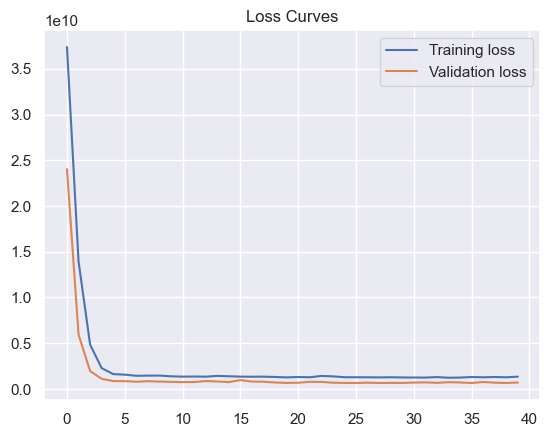

In [37]:
learning_rate = 0.5
epochs = 40
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1], activation="relu", input_dim=x_train.shape[1]
    )
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1], activation="relu", input_dim=x_train.shape[1]
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss="mse")
# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)


my_module.print_evaluate_regression(model.predict(x_test), y_test)

In [38]:
x_sub = df_final.loc[df_final["SalePrice"].isna()][features[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

pd.DataFrame({"Id": test_ID, "SalePrice": pred}).to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 2ms/step
